In [1]:
from qiskit import Aer, QuantumRegister, QuantumCircuit, transpile, execute
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit.quantum_info import state_fidelity

# Numerical/Stats pack
import pandas as pd
import numpy as np
import scipy.stats as ss
import numpy.linalg as nl
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns

# For optimization
from cvxopt import matrix, solvers
from scipy.optimize import minimize_scalar,minimize


from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter,MeasurementFilter)
import measfilter as mf # package for measurement error filter

# Choose Data Source

In [2]:
# Belem
# DataFileAddress = 'Bellbelem/'
# NoiseFileAddress = 'Bellbelem/'
# interested_qubits = [1,2] # Read from transpiled circuit diagram
# itrs = [1,3,5,10,15,20] # Read from data file
# n = 2 # Read from circuit diagram
# num_groups = 8 # Number of data points

# Athens
n = 2
interested_qubits = [2,3] # Qubit Order
itrs = [1,3,5,10,15]
DataFileAddress = 'BellAthens/'
NoiseFileAddress = 'BellAthens/'
num_groups = 15*8 # Number of data points

# Read Iterative Circuit Data

In [3]:
def counts_to_probs(counts):
    num_qubits = len(list(counts.keys())[0])
    counts_shots = np.sum([v for v in counts.values()])
    probs = np.zeros(2**(num_qubits), dtype=np.float64)
    for k,v in counts.items():
        probs[int(k,2)] = v/counts_shots
    return probs

In [4]:
# Read Bell State Data
mems = {} # Key is number of iterations
# real_counts = {}  # Key is number of iterations
# real_prob_dists = {} # Key is number of iterations
for itr in itrs:
    mems[itr] = np.load(DataFileAddress+'BellStateItr{:d}.npy'.format(itr))
#     real_counts[itr] = Counter(mems[itr])
#     real_prob_dists[itr] = counts_to_probs(real_counts[itr])
    
mems

{1: array(['01', '00', '00', ..., '00', '00', '00'], dtype='<U2'),
 3: array(['00', '00', '00', ..., '00', '00', '00'], dtype='<U2'),
 5: array(['00', '00', '00', ..., '00', '00', '00'], dtype='<U2'),
 10: array(['10', '01', '01', ..., '00', '00', '00'], dtype='<U2'),
 15: array(['00', '00', '00', ..., '01', '01', '01'], dtype='<U2')}

# Reconstruct Measurement Error Filter

In [5]:
# Qiskit Filter
state_labels = np.load(NoiseFileAddress+'state_labels.npy')
cal_matrix = np.load(NoiseFileAddress+'cal_matrix.npy')
qis_filter = MeasurementFilter(cal_matrix, state_labels)
qis_filter.cal_matrix

array([[9.88403320e-01, 3.41796875e-02, 2.60009766e-02, 7.32421875e-04],
       [7.32421875e-03, 9.62158203e-01, 3.66210938e-04, 3.08837891e-02],
       [4.27246094e-03, 0.00000000e+00, 9.66918945e-01, 3.30810547e-02],
       [0.00000000e+00, 3.66210938e-03, 6.71386719e-03, 9.35302734e-01]])

In [6]:
# qis_counts = {}
# qis_prob_dists = {}
# for key,val in real_counts.items():
#     qis_counts[key] = qis_filter.apply(val)
#     qis_prob_dists[key] = counts_to_probs(qis_counts[key])
    
# qis_counts, qis_prob_dists

In [7]:
# CB Filter
CB_filter = mf.MeasFilter(interested_qubits[::-1], file_address=NoiseFileAddress)
CB_filter.post_from_file()
# CB_filter.inference(nPrior=60000, Priod_sd=0.1, seed=751, shots_per_point=1024*8)
CB_filter.mean(), CB_filter.mat_mean

({'Qubit3': array([0.94532479, 0.90121807]),
  'Qubit2': array([0.93333858, 0.9347396 ])},
 array([[0.8823081 , 0.06169227, 0.09219698, 0.00644655],
        [0.0630167 , 0.88363252, 0.00658494, 0.09233538],
        [0.05103048, 0.00356813, 0.84114159, 0.05881385],
        [0.00364473, 0.05110708, 0.06007648, 0.84240422]]))

In [8]:
# CB_counts = {}
# CB_prob_dists = {}
# for key,val in real_counts.items():
#     CB_counts[key] = CB_filter.filter_mean(val)
#     CB_prob_dists[key] = counts_to_probs(CB_counts[key])
    
# CB_counts, CB_prob_dists

# Read Selected Iterative Circuit Data

In [9]:
def counts_to_probs(counts):
    num_qubits = len(list(counts.keys())[0])
    counts_shots = np.sum([v for v in counts.values()])
    probs = np.zeros(2**(num_qubits), dtype=np.float64)
    for k,v in counts.items():
        probs[int(k,2)] = v/counts_shots
    return probs

# Functions
def data_division(data, num_groups):
    groups = np.split(data, num_groups)
    group_counts = []
#     group_dists = np.zeros((2**len(data[0]), num_groups),dtype=np.float64)
    for i in range(num_groups):
        group_count = Counter(groups[i])
        group_counts.append(group_count)
#         group_dists[:,i] = counts_to_probs(group_count)
        
    return group_counts

In [10]:
selected_itr = 10 # Select a number of iterations from itrs in the first section

select_readouts = mems[selected_itr]
dists_data = data_division(select_readouts, num_groups)
dists_data
# dists_data, dists_data.sum(axis=0), len(dists_data.sum(axis=0))

[Counter({'10': 78, '01': 156, '00': 744, '11': 46}),
 Counter({'11': 31, '00': 795, '01': 137, '10': 61}),
 Counter({'00': 775, '10': 65, '01': 138, '11': 46}),
 Counter({'00': 719, '11': 47, '01': 182, '10': 76}),
 Counter({'10': 59, '00': 780, '01': 144, '11': 41}),
 Counter({'01': 139, '00': 778, '11': 39, '10': 68}),
 Counter({'00': 792, '11': 42, '01': 131, '10': 59}),
 Counter({'00': 767, '10': 78, '01': 140, '11': 39}),
 Counter({'00': 764, '11': 57, '01': 138, '10': 65}),
 Counter({'00': 764, '01': 139, '10': 87, '11': 34}),
 Counter({'00': 786, '01': 130, '11': 33, '10': 75}),
 Counter({'00': 741, '01': 165, '10': 83, '11': 35}),
 Counter({'00': 789, '11': 34, '01': 133, '10': 68}),
 Counter({'11': 42, '00': 788, '01': 130, '10': 64}),
 Counter({'11': 44, '00': 788, '01': 133, '10': 59}),
 Counter({'00': 775, '01': 135, '10': 67, '11': 47}),
 Counter({'00': 789, '01': 123, '10': 69, '11': 43}),
 Counter({'00': 774, '01': 144, '11': 42, '10': 64}),
 Counter({'00': 788, '01': 1

# Find VD Data

In [11]:
def VD(p,q):
    np_p = np.array(p)
    np_q = np.array(q)
    return 0.5*np.abs(np_p - np_q).sum()


def one_itr(qc):
    qc.h(0)
    qc.cx(0,1)
    qc.barrier()
    qc.cx(0,1)
    qc.h(0)
    qc.barrier()

# Bell0 state
def pure_circuit(name=None):
    r = QuantumRegister(n)
    qc = QuantumCircuit(r, name=name)
    for it in range(itr):
        one_itr(qc)
    return r, qc  

def noise_gates_circuit(noise_params):
    angles = noise_params.reshape((3, n)) #NOT A NUMPY ARRAY FROM SCIPY.OPTIMIZE
    
    r = QuantumRegister(n)
    qc = QuantumCircuit(r)
    for it in range(itr):
        one_itr(qc)
        for q in range(n):
            qc.u(angles[0,n-q-1], angles[1,n-q-1], angles[2,n-q-1], n-q-1) # Add noise/denoise here
        qc.barrier()
    return r, qc

In [12]:
true_r, true_qc = pure_circuit()
true_state = Statevector.from_instruction(true_qc)
true_prob = true_state.probabilities()

VD_data_real = np.array([VD(counts_to_probs(dists_data[g]), true_prob) for g in range(num_groups)])
VD_data_qis = np.array([VD(counts_to_probs(qis_filter.apply(dists_data[g])), true_prob) for g in range(num_groups)])
VD_data_CB = np.array([VD(counts_to_probs(CB_filter.filter_mean(dists_data[g])), true_prob) for g in range(num_groups)])

VD_data_real.shape, VD_data_real, VD_data_qis.shape, VD_data_qis, VD_data_CB.shape, VD_data_CB

((120,),
 array([0.2734375 , 0.22363281, 0.24316406, 0.29785156, 0.23828125,
        0.24023437, 0.2265625 , 0.25097656, 0.25390625, 0.25390625,
        0.23242187, 0.27636719, 0.22949219, 0.23046875, 0.23046875,
        0.24316406, 0.22949219, 0.24414062, 0.23046875, 0.24804687,
        0.21875   , 0.22851562, 0.24902344, 0.24609375, 0.25195312,
        0.22558594, 0.24804687, 0.24804687, 0.26269531, 0.26171875,
        0.22558594, 0.25585937, 0.25488281, 0.22558594, 0.24902344,
        0.24609375, 0.26269531, 0.26367187, 0.25292969, 0.24707031,
        0.26367187, 0.25195312, 0.24316406, 0.25292969, 0.25097656,
        0.23535156, 0.24804687, 0.22070312, 0.23242187, 0.25585937,
        0.23925781, 0.24316406, 0.25488281, 0.25488281, 0.24121094,
        0.23144531, 0.24121094, 0.25195312, 0.21386719, 0.25390625,
        0.25      , 0.23828125, 0.22949219, 0.24511719, 0.24804687,
        0.20410156, 0.23925781, 0.25292969, 0.22851562, 0.22070312,
        0.24902344, 0.22949219, 0.27929

# Inference

In [13]:
def tnorm01(center, sd, size=1):
    """ Generate random numbers for truncated normal with range [0,1]

    Args:
      center: float
        mean of normal distribution
      sd: float
        standard deviation of normal distribution
      size: int
        number of random numbers

    Returns: array
       an array of random numbers
    """
    upper = 2*np.pi
    lower = 0
    a, b = (lower - center) / sd, (upper - center) / sd
    return ss.truncnorm.rvs(a, b, size=size) * sd + center


def find_mode(data):
    """Find the mode through Gaussian KDE.

    Args:
      data: array
        an array of floats

    Returns: float
      the mode.
    """
    kde = ss.gaussian_kde(data)
    line = np.linspace(min(data), max(data), 10000)
    return line[np.argmax(kde(line))]


def closest_mode(post_lambdas):
    """Find the tuple of model parameters that closed to 
       the Maximum A Posteriori (MAP) of 
       posterior distribution of each parameter

    Args:
      post_lambdas: numpy array
        an n-by-m array where n is the number of posteriors and m is number 
        of parameters in the model

    Returns: numpy array
      an array that contains the required model parameters.
    """

    mode_lam = []
    for j in range(post_lambdas.shape[1]):
        mode_lam.append(find_mode(post_lambdas[:, j]))

    sol = np.array([])
    smallest_norm = nl.norm(post_lambdas[0])
    mode_lam = np.array(mode_lam)
    for lam in post_lambdas:
        norm_diff = nl.norm(lam - mode_lam)
        if norm_diff < smallest_norm:
            smallest_norm = norm_diff
            sol = lam
    return sol


def closest_average(post_lambdas):
    """Find the tuple of model parameters that closed to 
       the mean of posterior distribution of each parameter

    Args:
      post_lambdas: numpy array
        an n-by-m array where n is the number of posteriors and m is number 
        of parameters in the model

    Returns: numpy array
      an array that contains the required model parameters.
    """
    sol = np.array([])
    smallest_norm = nl.norm(post_lambdas[0])

    ave_lam = np.mean(post_lambdas, axis=0)

    for lam in post_lambdas:
        norm_diff = nl.norm(lam - ave_lam)

        if norm_diff < smallest_norm:
            smallest_norm = norm_diff
            sol = lam
    return sol


def QoI(prior_lambdas, true_prob):
    """
    Function equivalent to Q(lambda) in https://doi.org/10.1137/16M1087229

    Parameters
    ----------
    prior_lambdas : numpy array (num_priors, num_params)
        each subarray is an individual prior lambda.

    Returns
    -------
    qs : numpy array
        QoI's. Here they are the variation distance between simulated circuit output and true prob dist
    """
    # Find number of priors
    num_priors = prior_lambdas.shape[0]
    
    # For each prior, generate its simulation circuit and find the VD between its output
    if len(prior_lambdas.shape) == 1:
        r, param_qc = noise_gates_circuit(prior_lambdas)
        param_state = Statevector.from_instruction(param_qc)
        param_prob = param_state.probabilities()
        return VD(param_prob, true_prob)
    else:
        qs = np.array([], dtype=np.float64)
        for i in range(num_priors):
            r, param_qc = noise_gates_circuit(prior_lambdas[i])
            param_state = Statevector.from_instruction(param_qc)
            param_prob = param_state.probabilities()
            qs = np.append(qs, VD(param_prob, true_prob))
        return qs
        

def dq(x, qs_ker, d_ker):
    # if np.abs(qs_ker(x)[0])  > 0:
    #     if d_ker(x) == 0: # A lot of 0s in both sides may cause opt algorithm terminates
    #         # return np.abs(0.5-x)
    #         return np.infty
    #     else :
    #         return - d_ker(x)[0] / qs_ker(x)[0] 
    # else:
    #     return np.infty
    if np.abs(qs_ker(x)[0])  > 1e-6 and np.abs(d_ker(x)[0])  > 1e-6:
        return - d_ker(x)[0] / qs_ker(x)[0] 
    else:
        return np.infty


def findM(qs_ker, d_ker):
    """
    Function for finding the M, the largest r(Q(lambda)) over all lambda
    in Algorithm 2 of https://doi.org/10.1137/16M1087229
    
    we use minimize_scalar from scipy

    Parameters
    ----------
    qs_ker : scipy.stats.gaussian_kde
        the Q_D^{Q(prior)}(q) in Algorithm 1 of https://doi.org/10.1137/16M1087229.
    d_ker : scipy.stats.gaussian_kde
        pi_D^{obs}(q) in A997 of https://doi.org/10.1137/16M1087229.
    qs : numpy array
        samples generated from some given lambdas

    Returns
    -------
    M : float
        the largest r(Q(lambda)) over all lambda
    optimizer : float
        corresponding index of M

    """
    # M = -1  # probablities cannot be negative, so -1 is small enough
    # index = -1
    # for i in range(qs.size):
    #     if qs_ker(qs[i]) > 0:
    #         if M <= d_ker(qs[i]) / qs_ker(qs[i]):
    #             M = d_ker(qs[i]) / qs_ker(qs[i])
    #             index = i
    
#                
    xs = np.linspace(0, 1, 1000)
    ys = np.array([dq(x, qs_ker, d_ker) for x in xs])
#     plt.figure(figsize=(width,height), dpi=120, facecolor='white')
    plt.plot(xs, ys)
    plt.ylabel('-d/q')
    plt.xlabel('x')
    plt.show()
   
    # Remove consecutive np.inf, otherwise optimization will fail
    #rough_dq = ys[(ys<np.inf) & (np.abs(ys)>1e-3)]
    rough_xs = xs[ys<np.inf]
    bds = (rough_xs[0], rough_xs[-1])
    # res = minimize_scalar(dq, args =(qs_ker, d_ker) ,bounds=bounds, method='bounded', options={'maxiter': 5000})
    res = minimize(dq, (rough_xs[np.argmin(ys[ys<np.inf])],), args =(qs_ker, d_ker) ,bounds=(bds,), method='L-BFGS-B')
    
    
    try:
        return -res.fun[0], res.x[0]
    except Exception:
        return -res.fun, res.x



def output(d,
           M,
           prior_mean,
           prior_sd,
           true_prob,
           seed=127,
           file_address=''):
    """
      The main function that do all Bayesian inferrence part

    Parameters
    ----------
    d : array
        array of data (Observed QoI). Here, it is variation distance.
    M : int
        Number of priors required.
    prior_mean: array
        length is 3*num_qubits, range from 0 to 2pi
    prior_sd : float
        standard deviation for truncated normal distribution when generating 
        prior parameters (for measurement error).
    seed : int, optional
        Seed for random numbers. The default is 127.
    file_address : String, optional
        The relative file address to save posteriors and figures. 
        Ends with '/' if not empty
        The default is ''.

    Returns
    -------
    prior_lambdas : numpy array
        prior lambdas in the form of a-by-b matrix where 
        a is the number of priors and m is the number of model parameters
    post_lambdas : numpy array
        prior lambdas in the form of a-by-b matrix where 
        a is the number of posterior and m is the number of model parameters

    """
    # Algorithm 1 of https://doi.org/10.1137/16M1087229
    np.random.seed(seed)
    
    # Get distribution of data (Gaussian KDE)
    d_ker = ss.gaussian_kde(d)  # i.e., pi_D^{obs}(q), q = Q(lambda)

    # Sample prior lambdas, assume prior distribution is Normal distribution with mean as the given probality from IBM
    # Absolute value is used here to avoid negative values, so it is little twisted, may consider Gamma Distribution
    num_lambdas = 2*3
    prior_lambdas = np.zeros(M * num_lambdas).reshape((M, num_lambdas))
    for i in range(M):
        one_sample = np.zeros(num_lambdas)
        for j in range(num_lambdas):
#             one_sample[j] = tnorm01(prior_mean[j], prior_sd)
            one_sample[j] = np.random.uniform(0,2*np.pi)
        prior_lambdas[i] = one_sample

    # Produce prior QoI
    qs = QoI(prior_lambdas, true_prob)
    #print(qs)
    qs_ker = ss.gaussian_kde(qs)  # i.e., pi_D^{Q(prior)}(q), q = Q(lambda)

    # Algorithm 2 of https://doi.org/10.1137/16M1087229

    # Find the max ratio r(Q(lambda)) over all lambdas
    max_r, max_q = findM(qs_ker, d_ker)
    # Print and Check
    print('Final Accepted Posterior Lambdas')
    print('M: %.6g Maximizer: %.6g pi_obs = %.6g pi_Q(prior) = %.6g' %
          (max_r, max_q, d_ker(max_q), qs_ker(max_q)))

    post_lambdas = np.array([])
    # Go to Rejection Iteration
    for p in range(M):
        # Monitor Progress
        print('Progress: {:.3%}'.format(p/M), end='\r')
        
        r = d_ker(qs[p]) / qs_ker(qs[p])
        eta = r / max_r
        if eta > np.random.uniform(0, 1, 1):
            post_lambdas = np.append(post_lambdas, prior_lambdas[p])
    print()
    
    
    post_lambdas = post_lambdas.reshape(
        int(post_lambdas.size / num_lambdas),
        num_lambdas)  # Reshape since append destory subarrays
    post_qs = QoI(post_lambdas, true_prob)
    post_ker = ss.gaussian_kde(post_qs)
    np.save(file_address+'Post.npy', post_lambdas) # Save posteriors

    xs = np.linspace(0, 1, 1000)

    I = 0
    for i in range(xs.size - 1):
        q = xs[i]
        if qs_ker(q) > 0:
            r = d_ker(q) / qs_ker(q)
            I += r * qs_ker.pdf(q) * (xs[i + 1] - xs[i])  # Just Riemann Sum

    print('Accepted Number N: %.d, fraction %.3f' %
          (post_lambdas.shape[0], post_lambdas.shape[0] / M))
    print('I(pi^post_Lambda) = %.5g' % (I))  # Need to close to 1
    print('Posterior Lambda Mean', closest_average(post_lambdas))
    print('Posterior Lambda Mode', closest_mode(post_lambdas))
    
    print('0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = %6g' %
          (ss.entropy(post_ker(xs), d_ker(xs))))
    print('0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) = %6g' %
          (ss.entropy(d_ker(xs), post_ker(xs))))

    plt.plot(xs,
             d_ker(xs),
             color='Red',
             linestyle='dashed',
             linewidth=3,
             label='$\\pi^{\\mathrm{obs}}_{\\mathcal{D}}$')
    plt.plot(xs, post_ker(xs), color='Blue', label='$\\pi_{\\mathcal{D}}^{Q(\\mathrm{post})}$')
    plt.xlabel('VD')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.savefig(file_address + 'QoI-VD.pdf')
    plt.show()

    return prior_lambdas, post_lambdas

## Real Data

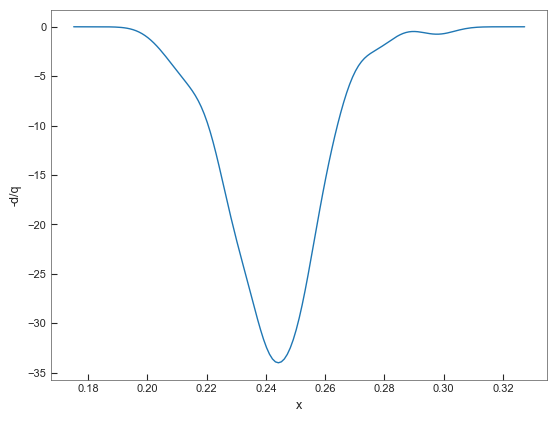

Final Accepted Posterior Lambdas
M: 33.9904 Maximizer: 0.244227 pi_obs = 27.6316 pi_Q(prior) = 0.812923
Progress: 99.995%
Accepted Number N: 608, fraction 0.030
I(pi^post_Lambda) = 1
Posterior Lambda Mean [2.03185735 4.24604441 2.88966817 3.04460874 3.45721175 2.8022531 ]
Posterior Lambda Mode [0.79138234 5.41334322 3.01598261 5.2903847  2.21052262 5.49374776]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.0114335
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


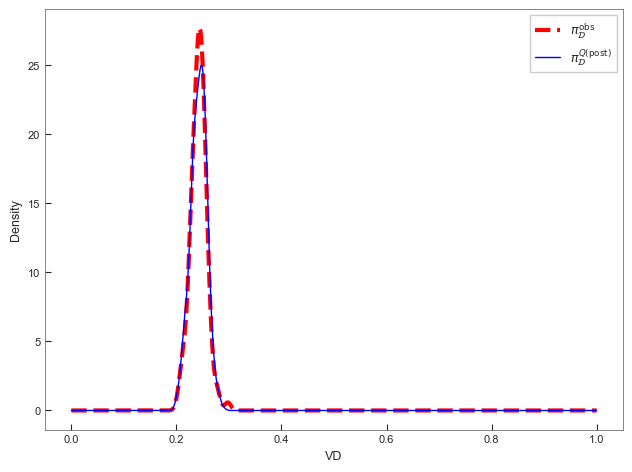

In [14]:
d = VD_data_real
M = 20000
prior_mean = [np.pi]*6
prior_sd = 1

prior_lambdas, post_lambdas = output(d, M, prior_mean, prior_sd, true_prob, seed=881, file_address=DataFileAddress)

[[2.03185735 4.24604441]
 [2.88966817 3.04460874]
 [3.45721175 2.8022531 ]]
Post-QoI: mean = 0.2423, sd = 0.01541


<AxesSubplot:ylabel='Density'>

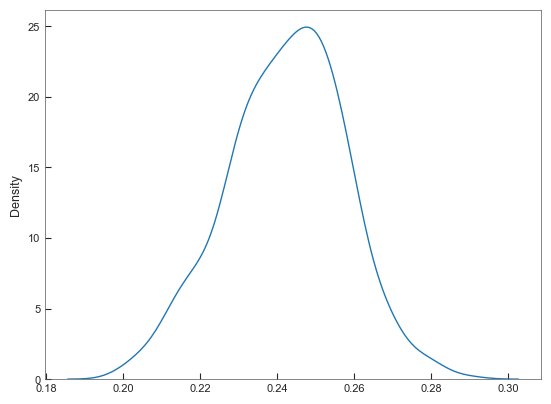

In [15]:
post_mean = closest_average(post_lambdas)
print(post_mean.reshape(3,2))

post_QoI = QoI(post_lambdas, true_prob)
print("Post-QoI: mean = {:.4g}, sd = {:.4g}".format(np.mean(post_QoI), np.std(post_QoI)))
sns.kdeplot(data=post_QoI)

Qubit 1, Angle #0: mean = 3.124, sd = 1.99
Qubit 1, Angle #1: mean = 3.149, sd = 1.796
Qubit 1, Angle #2: mean = 3.197, sd = 1.797
Qubit 0, Angle #0: mean = 3.182, sd = 2.091
Qubit 0, Angle #1: mean = 3.112, sd = 1.866
Qubit 0, Angle #2: mean = 3.264, sd = 1.835


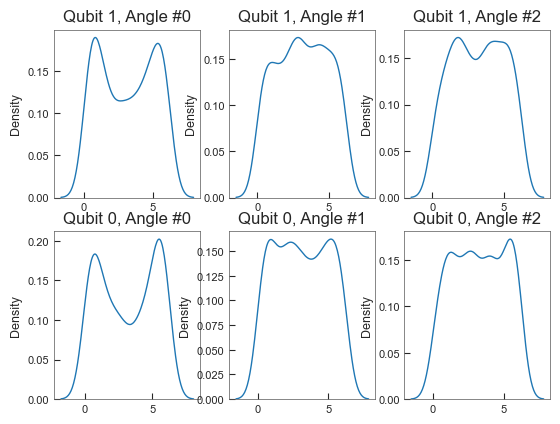

In [16]:
fig, axs = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        sns.kdeplot(data=post_lambdas[:,2*j+i], ax = axs[i,j])
        axs[i,j].set_title("Qubit {:d}, Angle #{:d}".format(n-i-1, j))
        print("Qubit {:d}, Angle #{:d}: mean = {:.4g}, sd = {:.4g}".format(n-i-1, j, 
                                                                           np.mean(post_lambdas[:,2*j+i]), 
                                                                           np.std(post_lambdas[:,2*j+i])))

## Qiskit Filtered

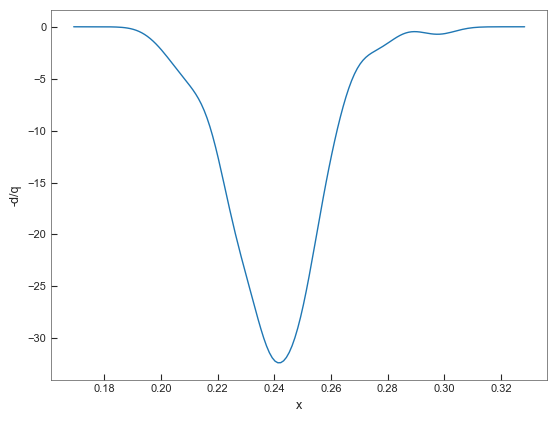

Final Accepted Posterior Lambdas
M: 32.3806 Maximizer: 0.241672 pi_obs = 26.3773 pi_Q(prior) = 0.814602
Progress: 99.995%
Accepted Number N: 631, fraction 0.032
I(pi^post_Lambda) = 1
Posterior Lambda Mean [2.03185735 4.24604441 2.88966817 3.04460874 3.45721175 2.8022531 ]
Posterior Lambda Mode [5.87522266 5.45222858 2.87290566 3.11211247 1.99467186 4.82530744]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.0117559
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


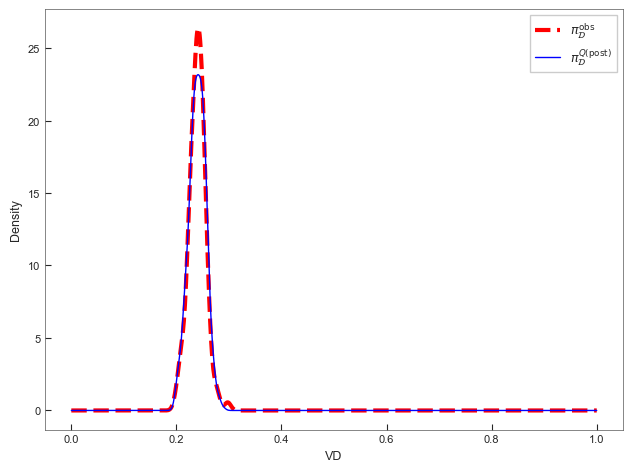

In [17]:
d = VD_data_qis
M = 20000
prior_mean = [np.pi]*6
prior_sd = 1

prior_lambdas_qis, post_lambdas_qis = output(d, M, prior_mean, prior_sd, true_prob, seed=881, file_address=DataFileAddress)

[[2.03185735 4.24604441]
 [2.88966817 3.04460874]
 [3.45721175 2.8022531 ]]
Post-QoI: mean = 0.2398, sd = 0.01601


<AxesSubplot:ylabel='Density'>

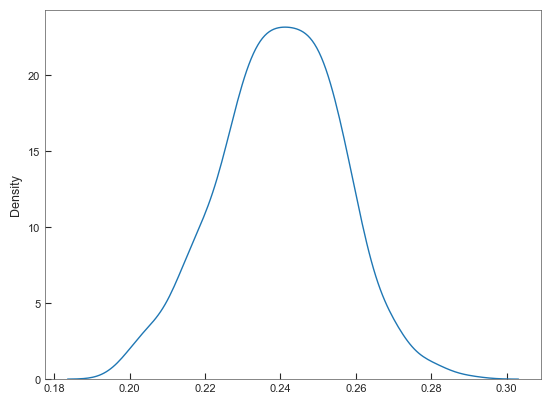

In [18]:
post_mean_qis = closest_average(post_lambdas_qis)
print(post_mean_qis.reshape(3,2))

post_QoI_qis = QoI(post_lambdas_qis, true_prob)
print("Post-QoI: mean = {:.4g}, sd = {:.4g}".format(np.mean(post_QoI_qis), np.std(post_QoI_qis)))
sns.kdeplot(data=post_QoI_qis)

Qubit 1, Angle #0: mean = 3.176, sd = 1.984
Qubit 1, Angle #1: mean = 3.169, sd = 1.785
Qubit 1, Angle #2: mean = 3.198, sd = 1.803
Qubit 0, Angle #0: mean = 3.184, sd = 2.088
Qubit 0, Angle #1: mean = 3.139, sd = 1.861
Qubit 0, Angle #2: mean = 3.274, sd = 1.827


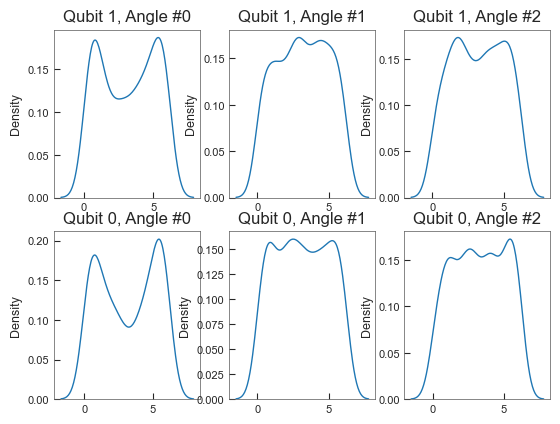

In [19]:
fig, axs = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        sns.kdeplot(data=post_lambdas_qis[:,2*j+i], ax = axs[i,j])
        axs[i,j].set_title("Qubit {:d}, Angle #{:d}".format(n-i-1, j))
        print("Qubit {:d}, Angle #{:d}: mean = {:.4g}, sd = {:.4g}".format(n-i-1, j, 
                                                                           np.mean(post_lambdas_qis[:,2*j+i]), 
                                                                           np.std(post_lambdas_qis[:,2*j+i])))

## CB Filtered

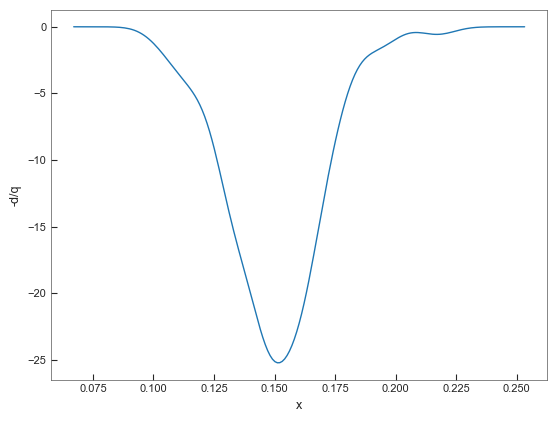

Final Accepted Posterior Lambdas
M: 25.2156 Maximizer: 0.15157 pi_obs = 22.0045 pi_Q(prior) = 0.872652
Progress: 99.995%
Accepted Number N: 756, fraction 0.038
I(pi^post_Lambda) = 1
Posterior Lambda Mean [3.96800627 3.84731157 2.60333356 2.85402945 2.11807251 2.72145877]
Posterior Lambda Mode [0.92983798 5.52245567 1.68133517 3.40888858 0.65044692 4.79269688]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.0111568
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


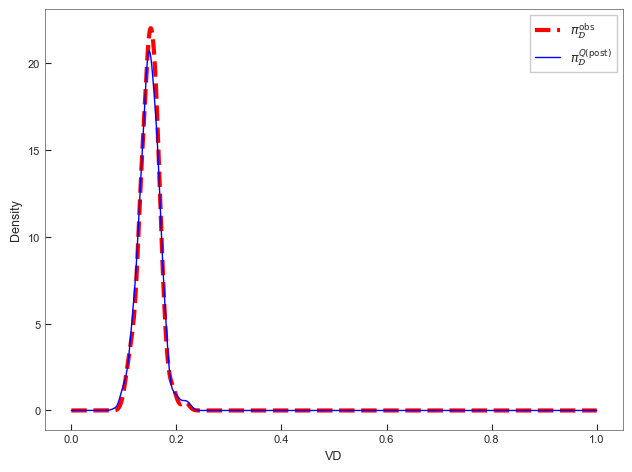

In [20]:
d = VD_data_CB
M = 20000
prior_mean = [np.pi]*6
prior_sd = 1

prior_lambdas_CB, post_lambdas_CB = output(d, M, prior_mean, prior_sd, true_prob, seed=881, file_address=DataFileAddress)

[[3.96800627 3.84731157]
 [2.60333356 2.85402945]
 [2.11807251 2.72145877]]
Post-QoI: mean = 0.1487, sd = 0.02069


<AxesSubplot:ylabel='Density'>

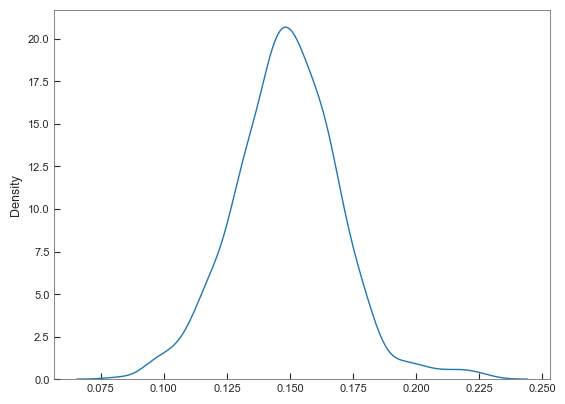

In [21]:
post_mean_CB = closest_average(post_lambdas_CB)
print(post_mean_CB.reshape(3,2))

post_QoI_CB = QoI(post_lambdas_CB, true_prob)
print("Post-QoI: mean = {:.4g}, sd = {:.4g}".format(np.mean(post_QoI_CB), np.std(post_QoI_CB)))
sns.kdeplot(data=post_QoI_CB)

Qubit 1, Angle #0: mean = 3.122, sd = 2.091
Qubit 1, Angle #1: mean = 3.064, sd = 1.81
Qubit 1, Angle #2: mean = 3.115, sd = 1.848
Qubit 0, Angle #0: mean = 3.285, sd = 2.112
Qubit 0, Angle #1: mean = 3.075, sd = 1.777
Qubit 0, Angle #2: mean = 3.222, sd = 1.807


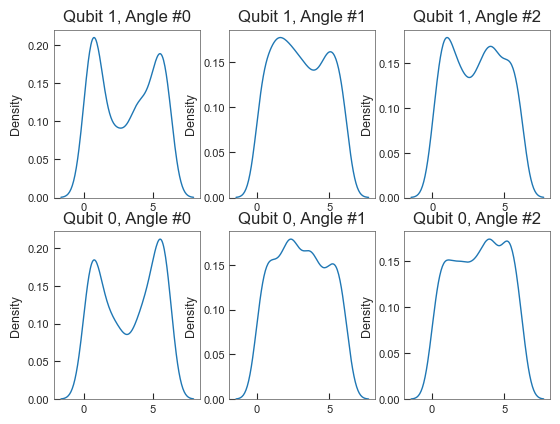

In [22]:
fig, axs = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        sns.kdeplot(data=post_lambdas_CB[:,2*j+i], ax = axs[i,j])
        axs[i,j].set_title("Qubit {:d}, Angle #{:d}".format(n-i-1, j))
        print("Qubit {:d}, Angle #{:d}: mean = {:.4g}, sd = {:.4g}".format(n-i-1, j, 
                                                                           np.mean(post_lambdas_CB[:,2*j+i]), 
                                                                           np.std(post_lambdas_CB[:,2*j+i])))